In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

%matplotlib inline

from src.helpers import get_FD_matrix, calculate_relgap, plot_eigenvalues, spectral_scale
from src.experiments import approximation_convergence, get_bound_taylor, get_bound_chebyshev

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Read/build the matrices

In [3]:
# orani678 = sp.io.mmread('data/orani678.mtx').tocsc()
# bcspwr10 = sp.io.mmread('data/bcspwr10.mtx').tocsc()
# gr_30_30 = sps.csc_matrix(sp.io.mmread('data/gr_30_30.mtx').toarray().astype(np.float64))  # NOTE: Stored as int
# helm2d03 = sp.io.mmread('data/helm2d03.mtx').tocsc()

In [3]:
def get_test_matrices(n: int, a: float, b: float):
    # Check the shape of the 2D Laplace matrix
    assert (n ** .5) % 1 == 0

    # 1D Laplace stiffness matrix
    A1 = spectral_scale(A=get_FD_matrix(n=n, d=1, scale=False), a=a, b=b)
    # 2D Laplace stiffness matrix
    A2 = spectral_scale(A=get_FD_matrix(n=(n ** .5), d=2, scale=False), a=a, b=b)
    # Diagonal uniformly distributed eigenvalues
    A3 = sps.diags(np.linspace(a, b, n))
    # Diagonal geometrically distributed eigenvalues
    A4 = sps.diags(+np.geomspace(a, b or (b-1e-10), n))
    # Diagonal reversed geometrically distributed eigenvalues
    A5 = sps.diags(-np.geomspace(a, b or (b-1e-10), n) + b + a)

    return A1, A2, A3, A4, A5


## Analyze the matrices

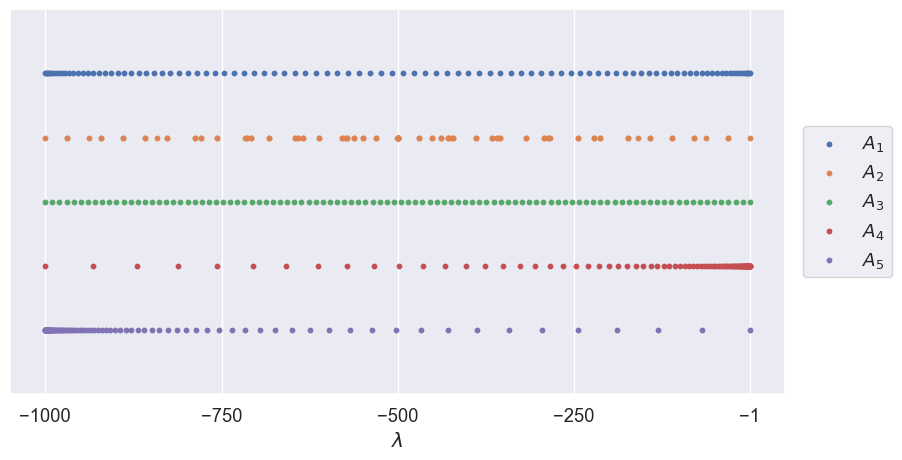

In [8]:
# Eigenvalue distribution

plot_eigenvalues(
    As=[*get_test_matrices(n=100, a=-1000, b=-1)],
    legends=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$'],\
    xticks=[-1000, -750, -500, -250, -1]
    # range_=(-1000, 0),
)

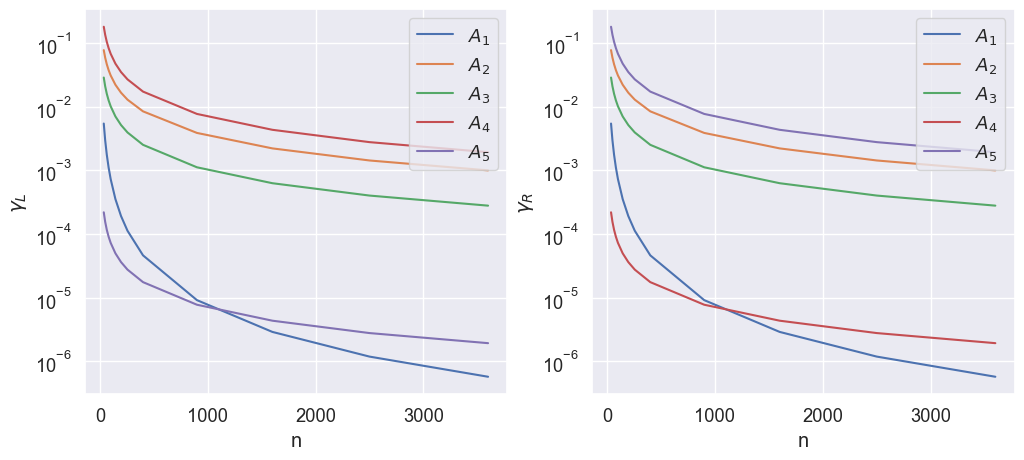

In [56]:
# Relative gap

names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
data = {'n': [], 'Matrix': [], 'g_l': [], 'g_r': []}
a, b = -1000, -1
for n in [n ** 2 for n in [6, 7, 8, 9, 10, 12, 14, 16, 20, 30, 40, 50, 60]]:
    I = sps.identity(n=n)
    for idx, A in enumerate(get_test_matrices(n=n, a=a, b=b)):
        data['n'].append(n)
        data['Matrix'].append(names[idx])
        g_l, g_r = calculate_relgap(A, lam_min1=a, lam_max1=b)
        data['g_l'].append(g_l)
        data['g_r'].append(g_r)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_l', hue='Matrix', ax=axs[0])
axs[0].set(yscale='log', ylabel='$\gamma_L$', xlabel='n')
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_r', hue='Matrix', ax=axs[1])
axs[1].set(yscale='log', ylabel='$\gamma_R$', xlabel='n')
for ax in axs:
    ax.legend()

# Convergence results for $\varphi(A)v$

## Run the experiments

In [4]:
mmax_PA = 600
mmax_RA = 100
ns = [n ** 2 for n in [10, 20, 30, 40, 50, 60, 70, 80, 100]]
as_ = [-a for a in [1000, 5000, 10000]]
n_matrices = 5
b = -1


pbar = tqdm(total=(len(ns) * len(as_) * n_matrices))
ds = []
for n in ns:
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
    matrices = list()
    for a in as_:
        for name, A in zip(names[:n_matrices], get_test_matrices(n=n, a=a, b=b)[:n_matrices]):
            d = approximation_convergence(
                A=A,
                v=v,
                nms=50,
                ps=[0, 1, 3, 5, 10],
                mmax_PA=min(n, mmax_PA),
                mmax_RA=min(n, mmax_RA),
            )
            d['name'] = [name] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

            d = get_bound_chebyshev(
                ps=[1],
                mmax=mmax_PA,
                nms=50,
                alpha=abs(a),
                vnorm=1,
            )
            d['name'] = ['Estimation #2'] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

            # NOTE: Error because of large factorials
            # d = get_bound_taylor(
            #     ps=range(4),
            #     mmax=mmax_PA,
            #     nms=50,
            #     alpha=abs(a),
            #     vnorm=1,
            # )
            # d['name'] = ['Estimation #1'] * len(d['err'])
            # d['n'] = [n] * len(d['err'])
            # d['a'] = [a] * len(d['err'])
            # ds.append(d)

            pbar.update()

pbar.close()

 12%|█▏        | 16/135 [01:36<18:35,  9.38s/it]/Users/sepehr/miniconda3/envs/anchp/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
100%|██████████| 135/135 [4:56:34<00:00, 131.81s/it]  


In [5]:
# Save the experiments
df = pd.concat([pd.DataFrame(d) for d in ds])
df.to_csv('experiments.csv', index=False)

In [39]:
# Load the experiments
df = pd.read_csv('experiments.csv')

In [ ]:
# TMP
mmax_PA = 600
mmax_RA = 100
ns = [n ** 2 for n in [200, 300]]
as_ = [-a for a in [1000, 5000, 10000]]
n_matrices = 5
b = -1


pbar = tqdm(total=(len(ns) * len(as_) * n_matrices))
ds = []
for n in ns:
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
    matrices = list()
    for a in as_:
        for name, A in zip(names[:n_matrices], get_test_matrices(n=n, a=a, b=b)[:n_matrices]):
            d = approximation_convergence(
                A=A,
                v=v,
                nms=50,
                ps=[0, 1, 3, 5, 10],
                mmax_PA=min(n, mmax_PA),
                mmax_RA=min(n, mmax_RA),
            )
            d['name'] = [name] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)

            d = get_bound_chebyshev(
                ps=[1],
                mmax=mmax_PA,
                nms=50,
                alpha=abs(a),
                vnorm=1,
            )
            d['name'] = ['Estimation #2'] * len(d['err'])
            d['n'] = [n] * len(d['err'])
            d['a'] = [a] * len(d['err'])
            ds.append(d)


            pbar.update()

pbar.close()

In [ ]:
df_ = pd.concat([pd.DataFrame(d) for d in ds])
df = pd.read_csv('experiments.csv')
df = pd.concat(df, df_)

## Convergence for different $\varphi$-functions

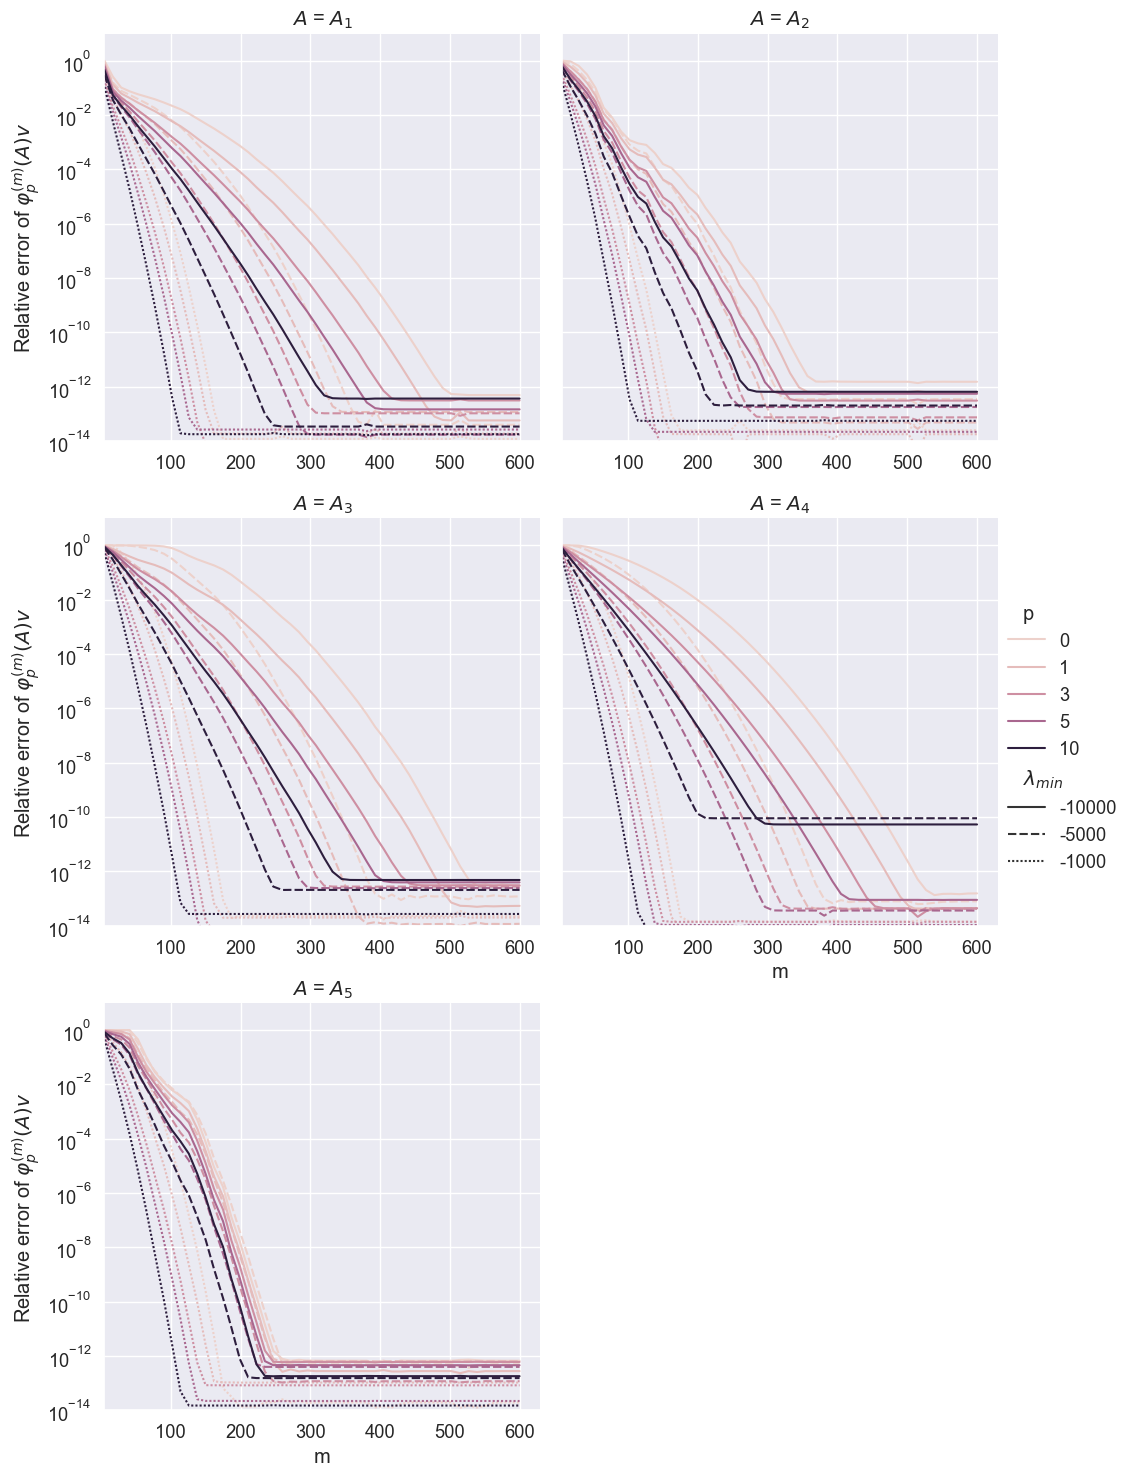

In [16]:
data = df[
    ((df['method'] == 'PA'))
    & ((df['name'] != 'Estimation #2'))
    & (df['n'] == 10000)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda_{min}$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
);

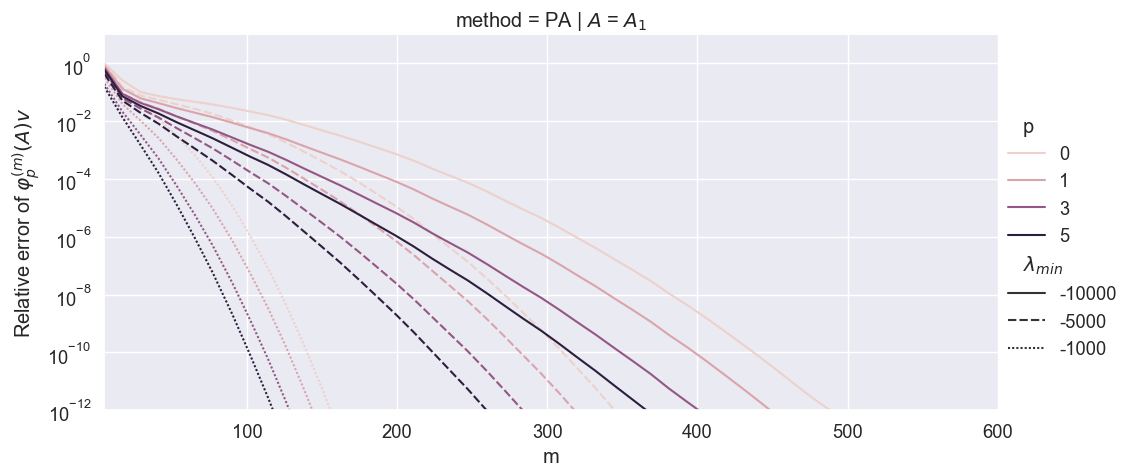

In [36]:
data = df[
    # phi functions
    (df['p'] != 10)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    # & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    row='method',
    style='$\\lambda_{min}$',
    # col_wrap=2,
    facet_kws={'sharex': False},
    height=5,
    aspect=2,
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
);
fg.axes[0, 0].set(xlim=[5, 600]);

## Convergence for different matrices

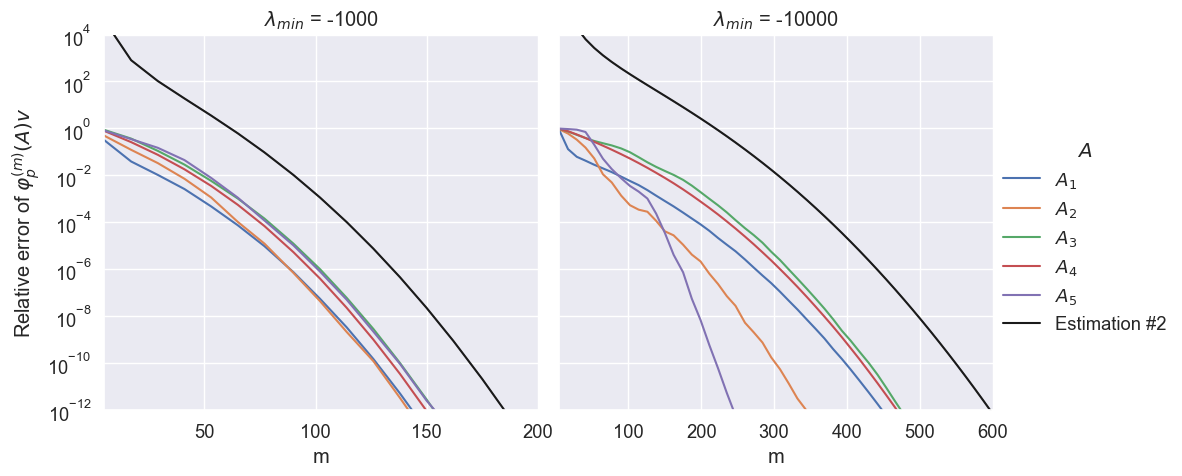

In [45]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & ((df['n'] == 10000))

    # Smallest eigenvalue
    & ((df['a'] == -10000) | (df['a'] == -1000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='$A$',
    # style='p',
    col='$\\lambda_{min}$',
    col_wrap=2,
    hue_order=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$', 'Estimation #2'],
    col_order=[-1000, -10000],
    facet_kws={'sharex': False},
    palette=['C0', 'C1', 'C2', 'C3', 'C4', 'k'],
)
ax = plt.gca()
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+04],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
);
fg.axes[0].set(xlim=[5, 200]);
fg.axes[1].set(xlim=[5, 600]);

## Convergence with different methods

[(5.0, 250.0)]

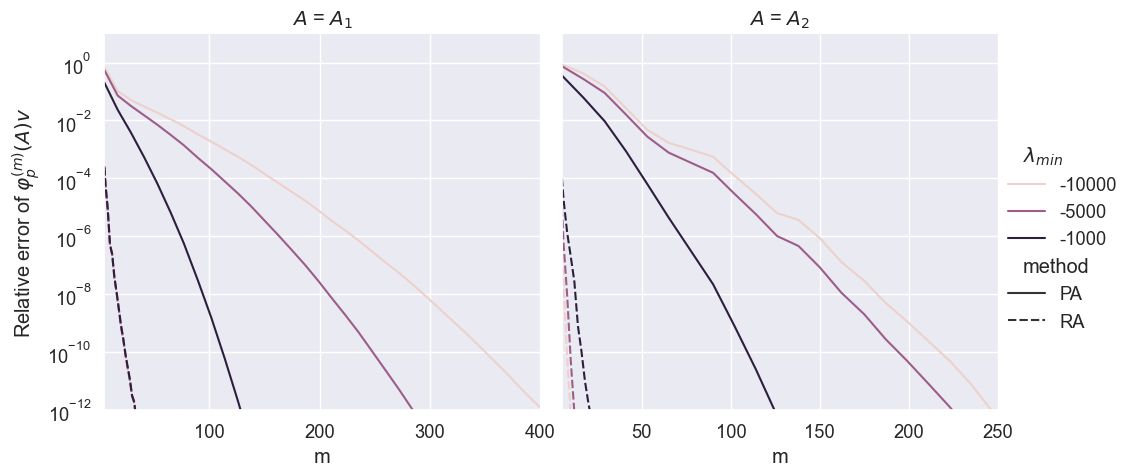

In [47]:
# TODO: Use this for comparing RA and RA-AAA

data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    & ((df['method'] != 'EX'))

    # Matrices
    & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 4900)

    # Smallest eigenvalue
    & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='$\\lambda_{min}$',
    col='$A$',
    style='method',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
)
fg.axes[0].set(xlim=[5, 400])
fg.axes[1].set(xlim=[5, 250])

## Convergence with different n

Show that RA has mesh-independent convergence, whereas PA does not. Cite the review paper of Guttel for that.

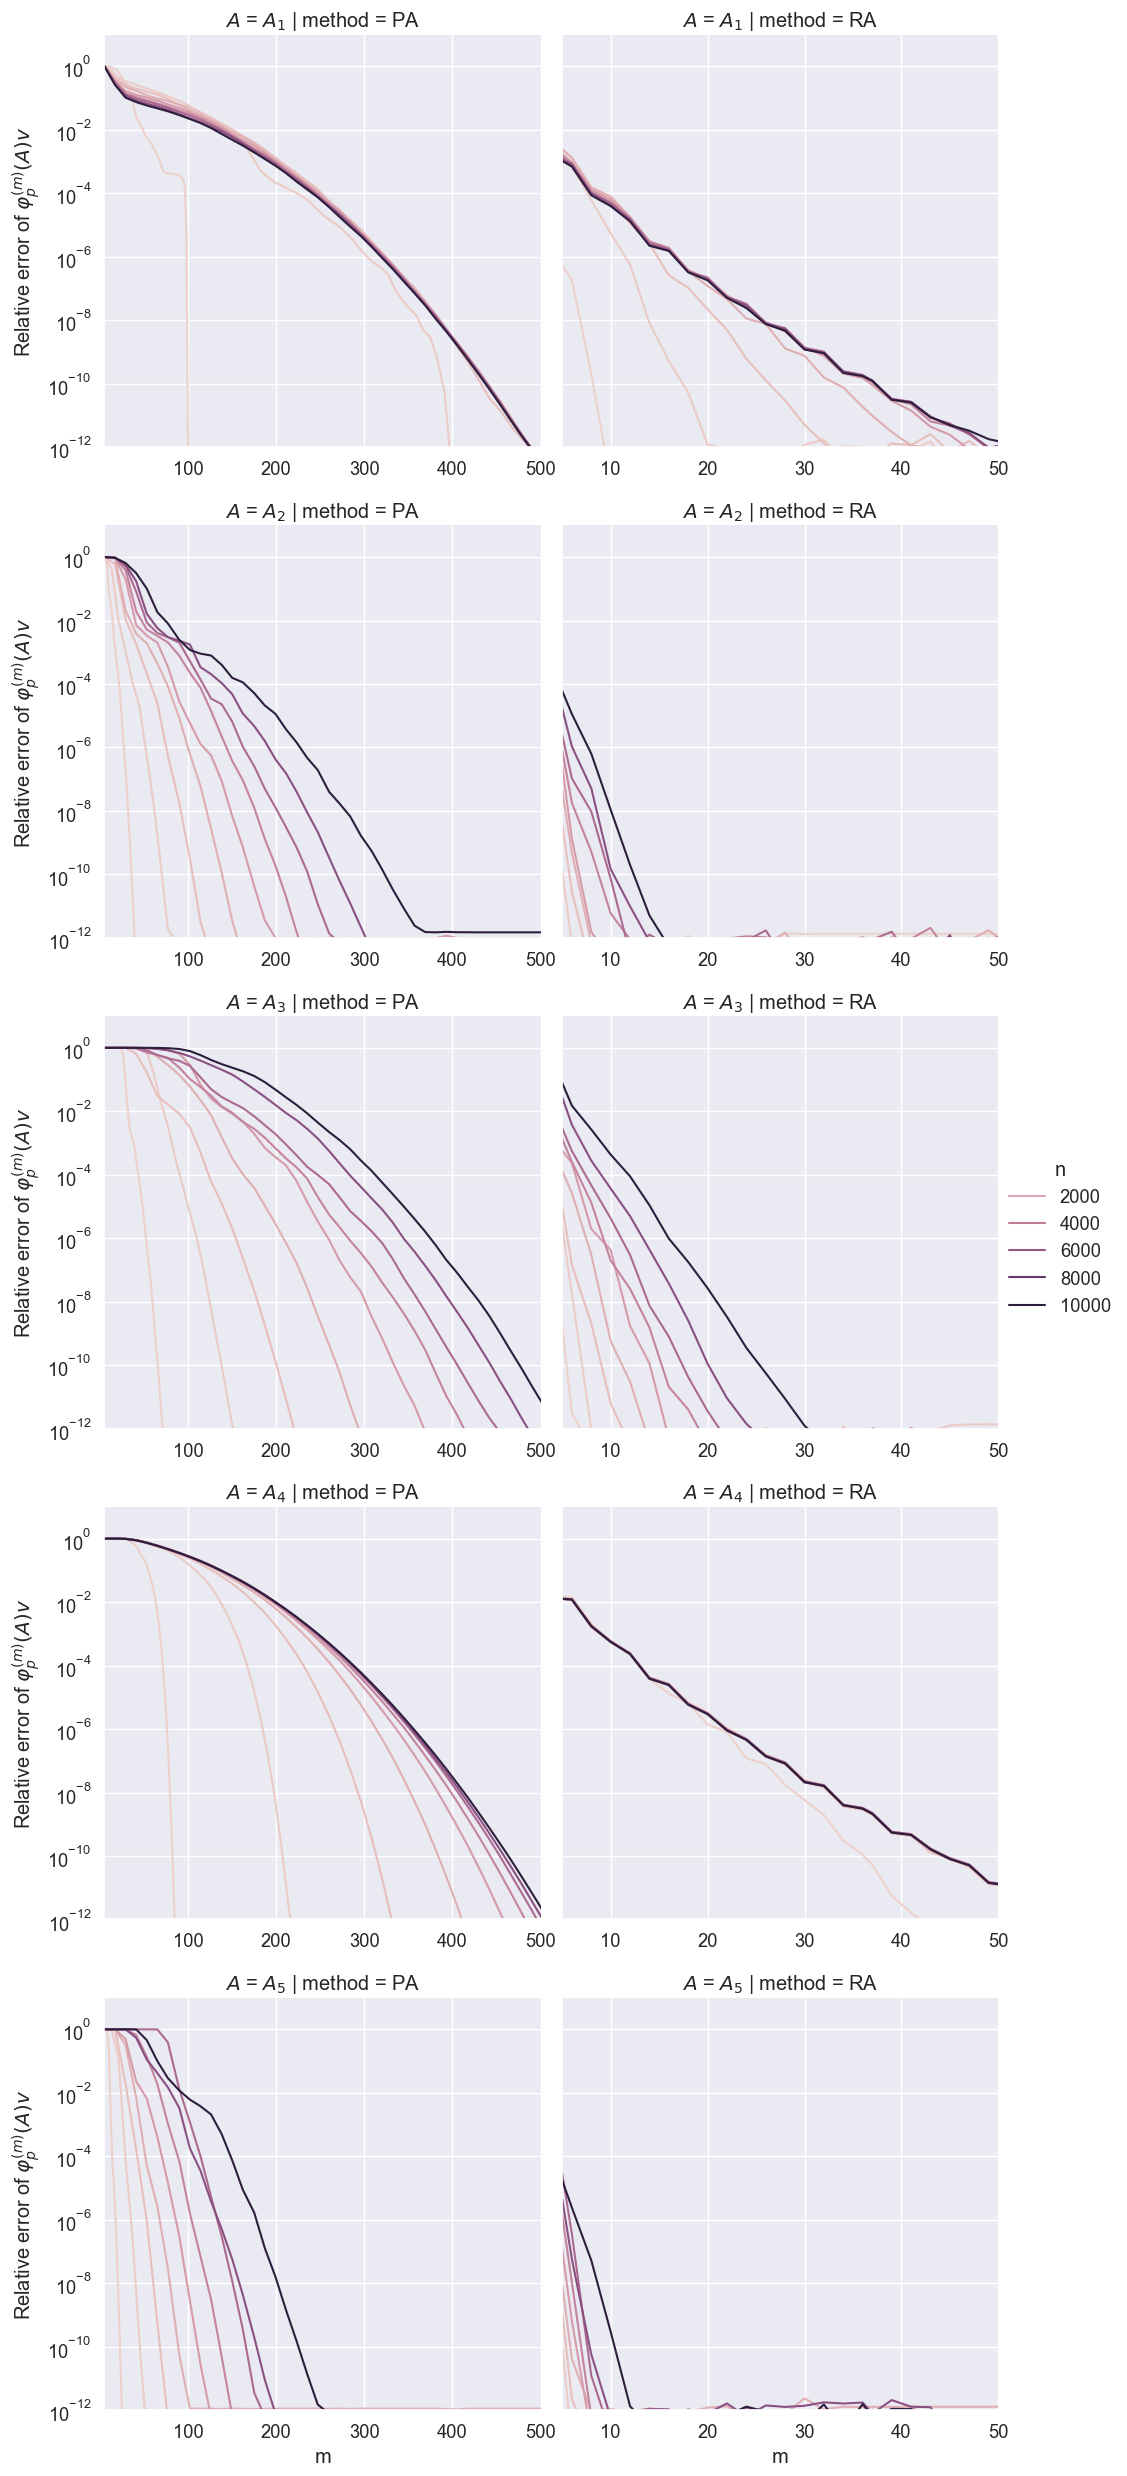

In [64]:
data = df[
    # phi functions
    (df['p'] == 0)

    # Method
    & ((df['method'] != 'EX'))

    # Matrices
    & ((df['name'] != '$Estimation #2$'))

    # Size
    # & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == -10000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'}),
    x='m',
    y='err',
    kind='line',
    hue='n',
    col='method',
    row='$A$',
    # col_wrap=2,
    facet_kws={'sharex': False}
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='Relative error of $\\varphi_p^{(m)}(A)v$',
)
fg.axes[0, 0].set(xlim=[5, 500]);
fg.axes[0, 1].set(xlim=[5, 50]);
fg.axes[1, 0].set(xlim=[5, 500]);
fg.axes[1, 1].set(xlim=[5, 50]);
fg.axes[2, 0].set(xlim=[5, 500]);
fg.axes[2, 1].set(xlim=[5, 50]);
fg.axes[3, 0].set(xlim=[5, 500]);
fg.axes[3, 1].set(xlim=[5, 50]);
fg.axes[4, 0].set(xlim=[5, 500]);
fg.axes[4, 1].set(xlim=[5, 50]);

## CPU time with different n

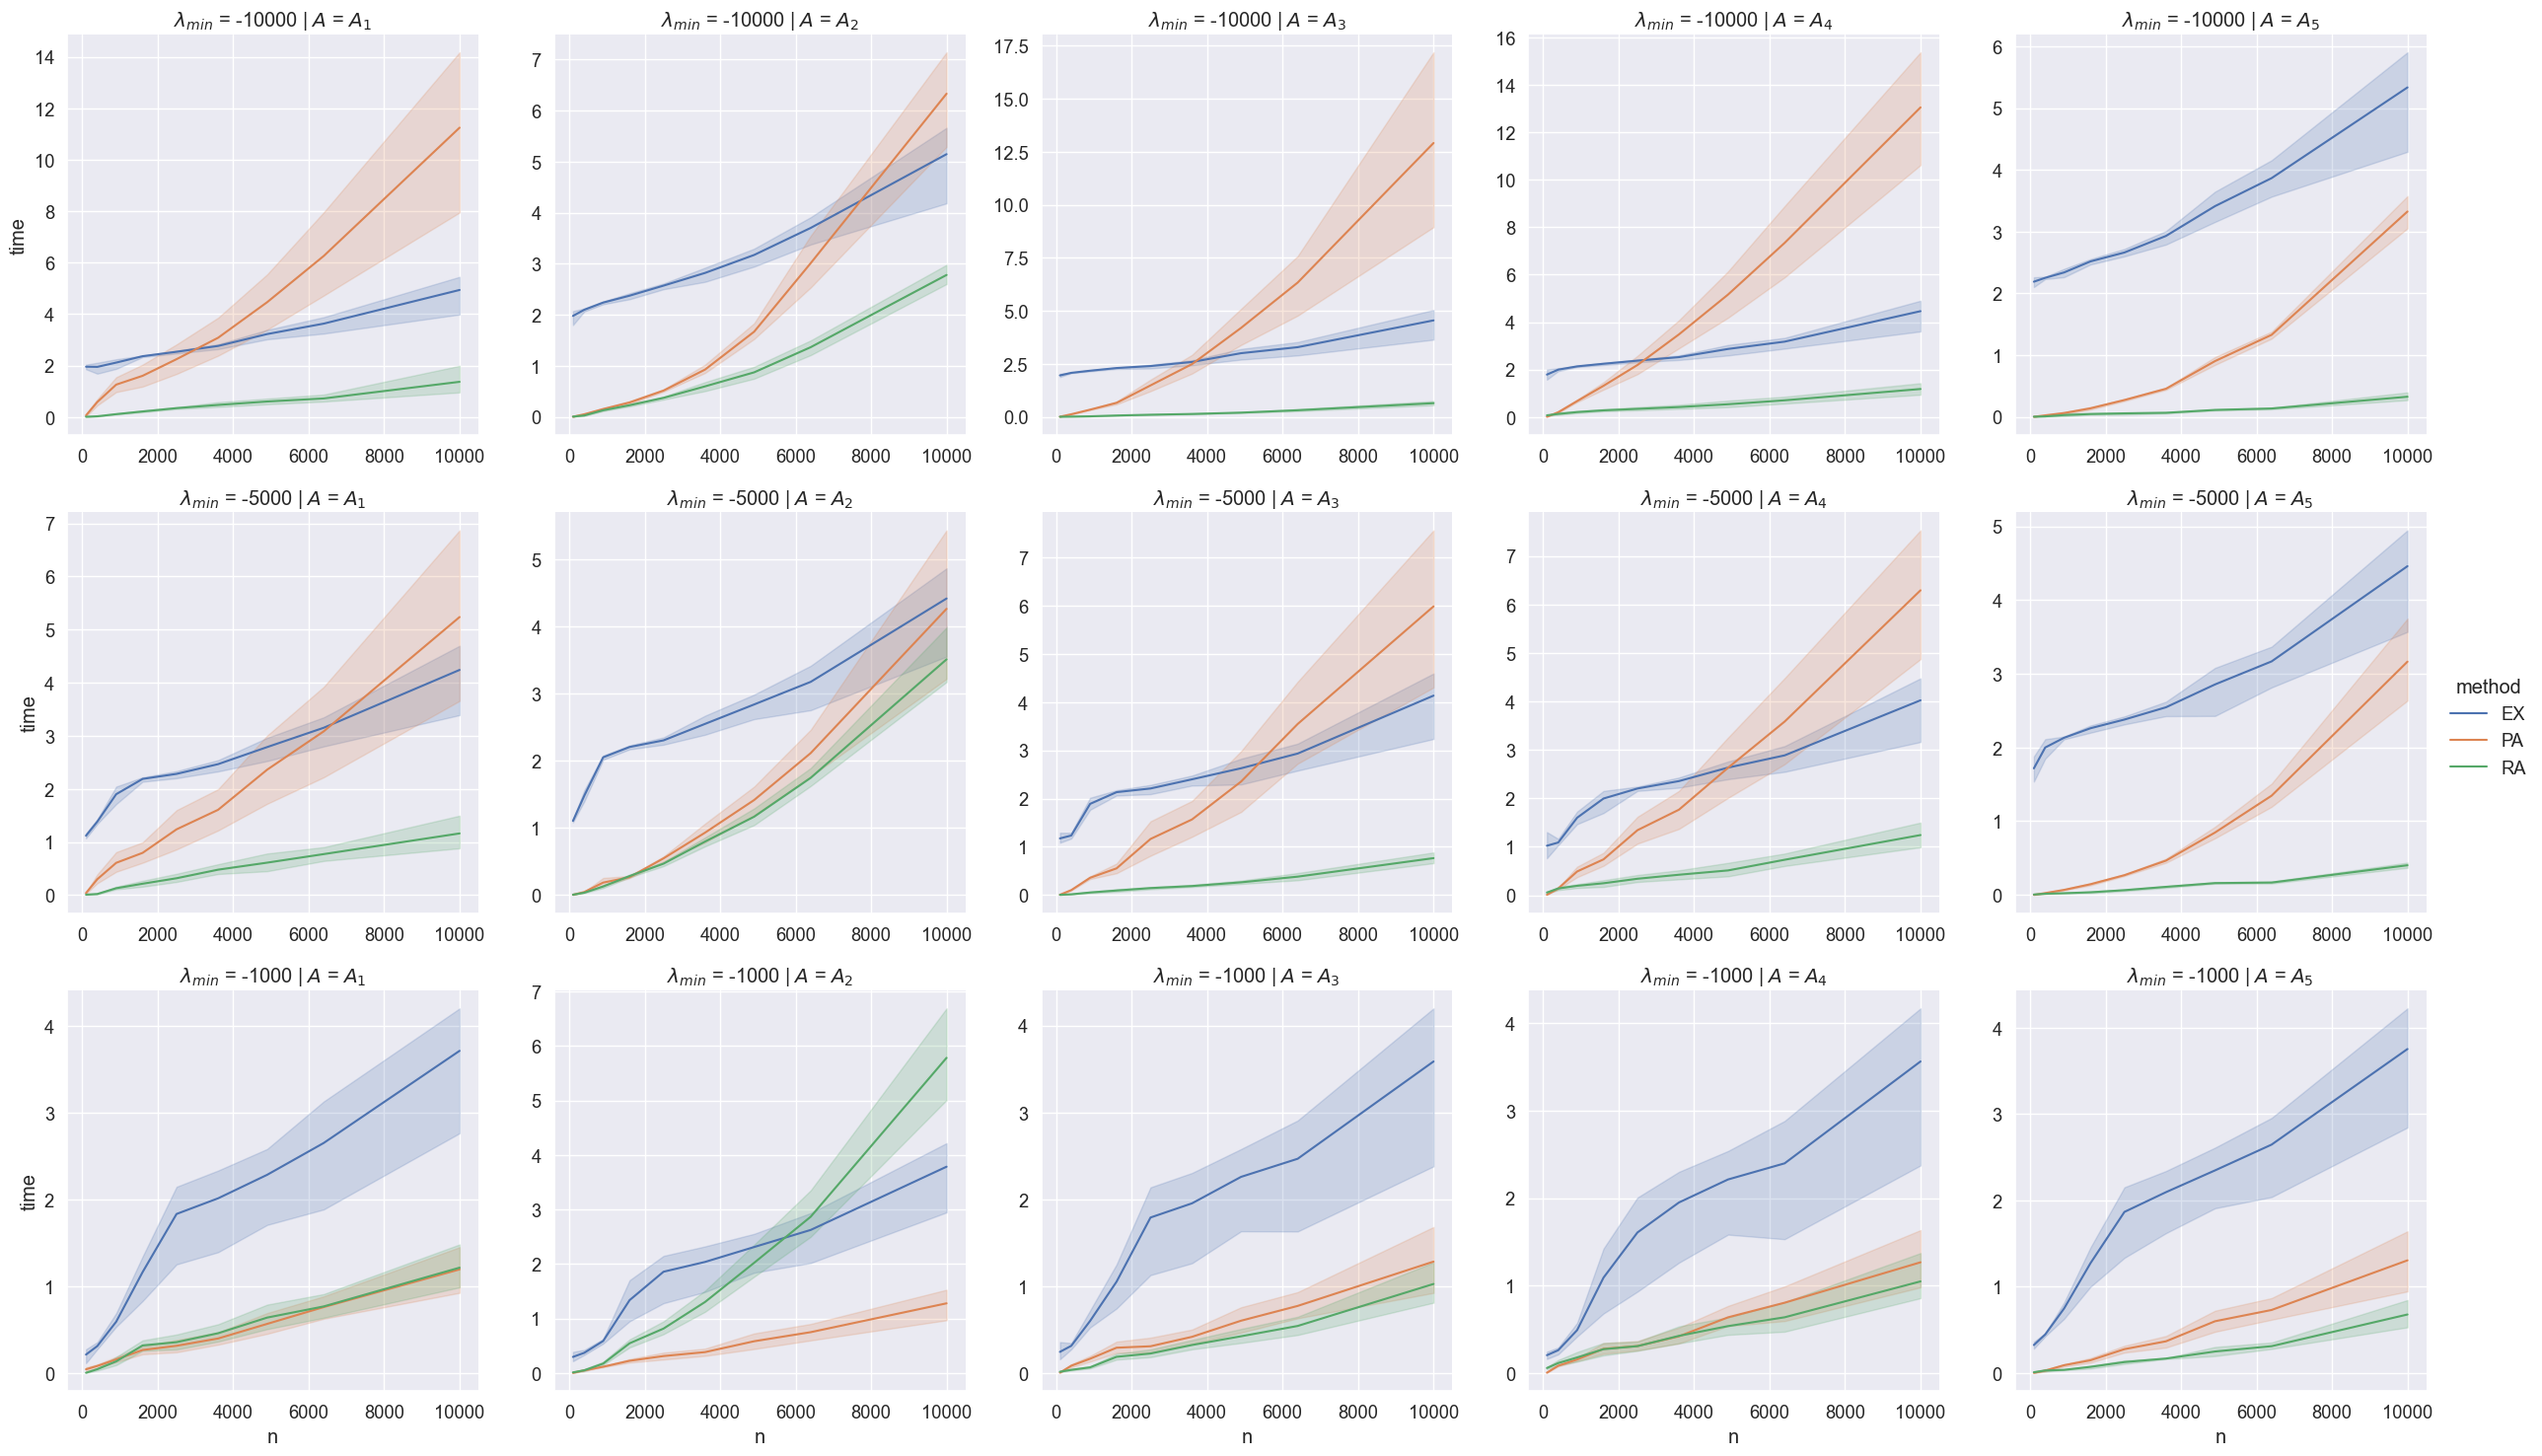

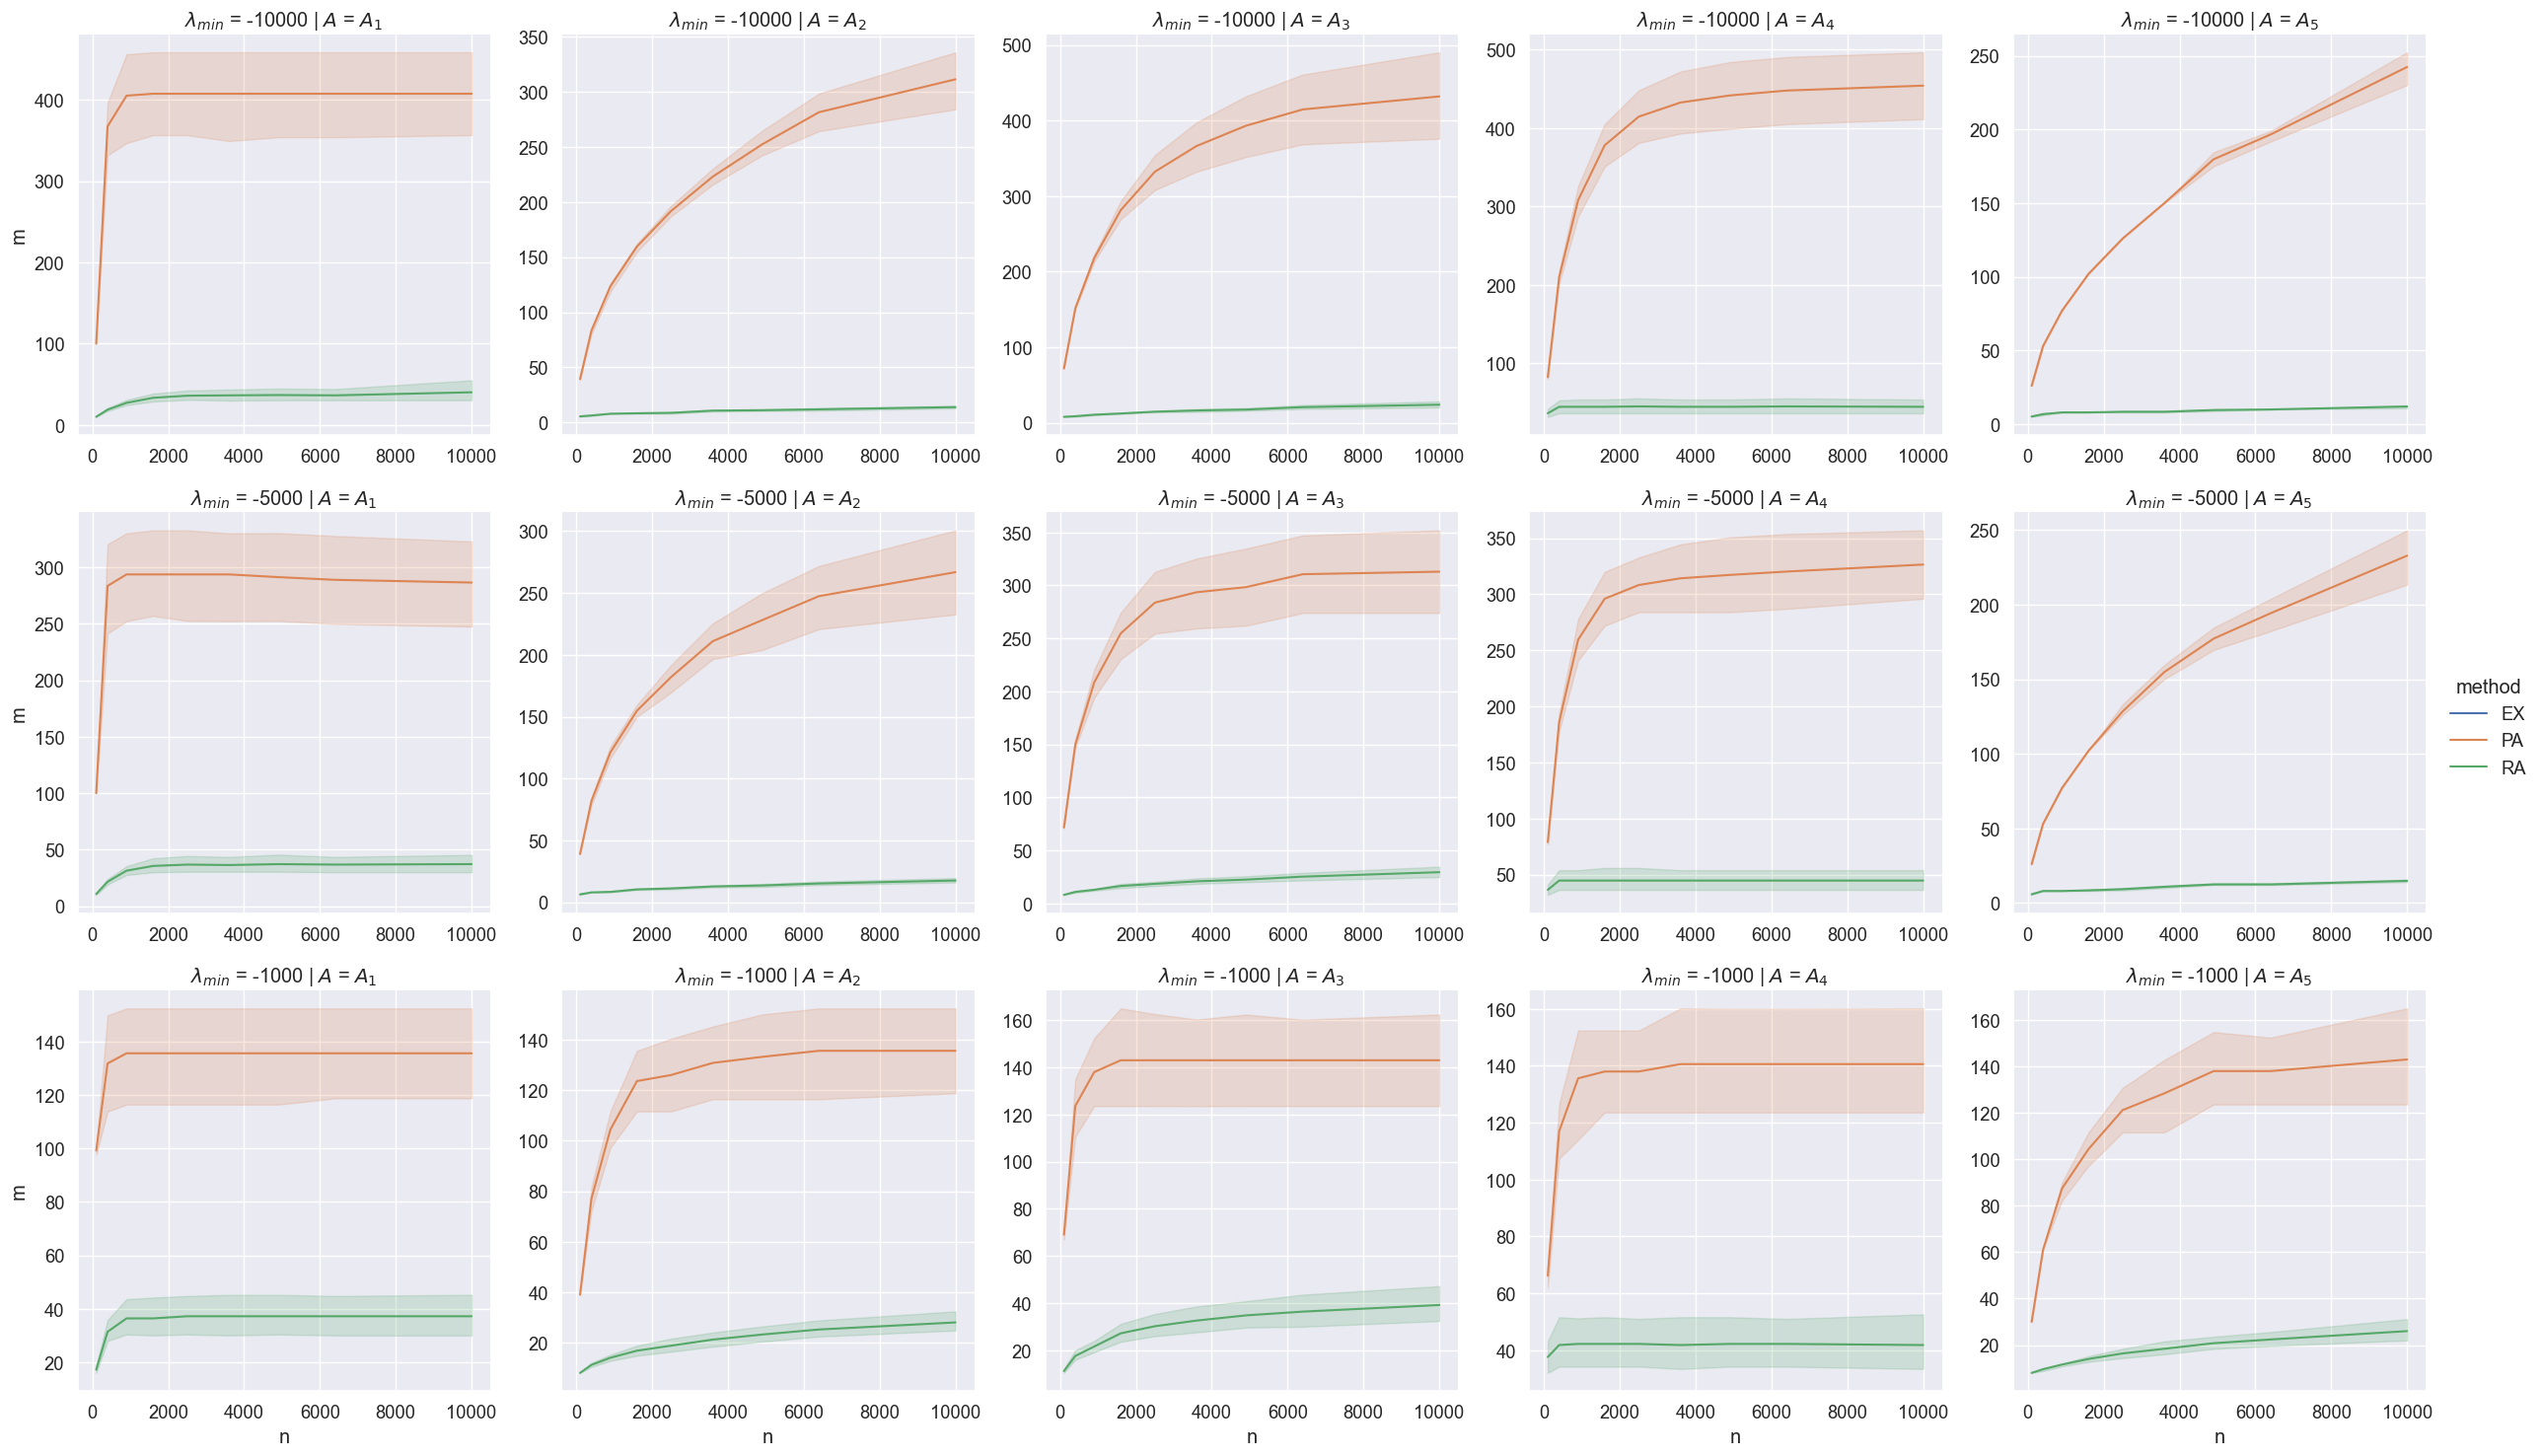

In [66]:
data = df[
    ((df['name'] != 'Estimation #2'))
]

thresh = 1e-12
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda_{min}$', 'p', '$A$', 'n']).aggregate(np.min)

# Plot CPU time
fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda_{min}$',
    facet_kws={'sharex': False, 'sharey': False}
)

# Plot smallest m
fg = sns.relplot(
    data=data,
    x='n',
    y='m',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda_{min}$',
    facet_kws={'sharex': False, 'sharey': False}
)

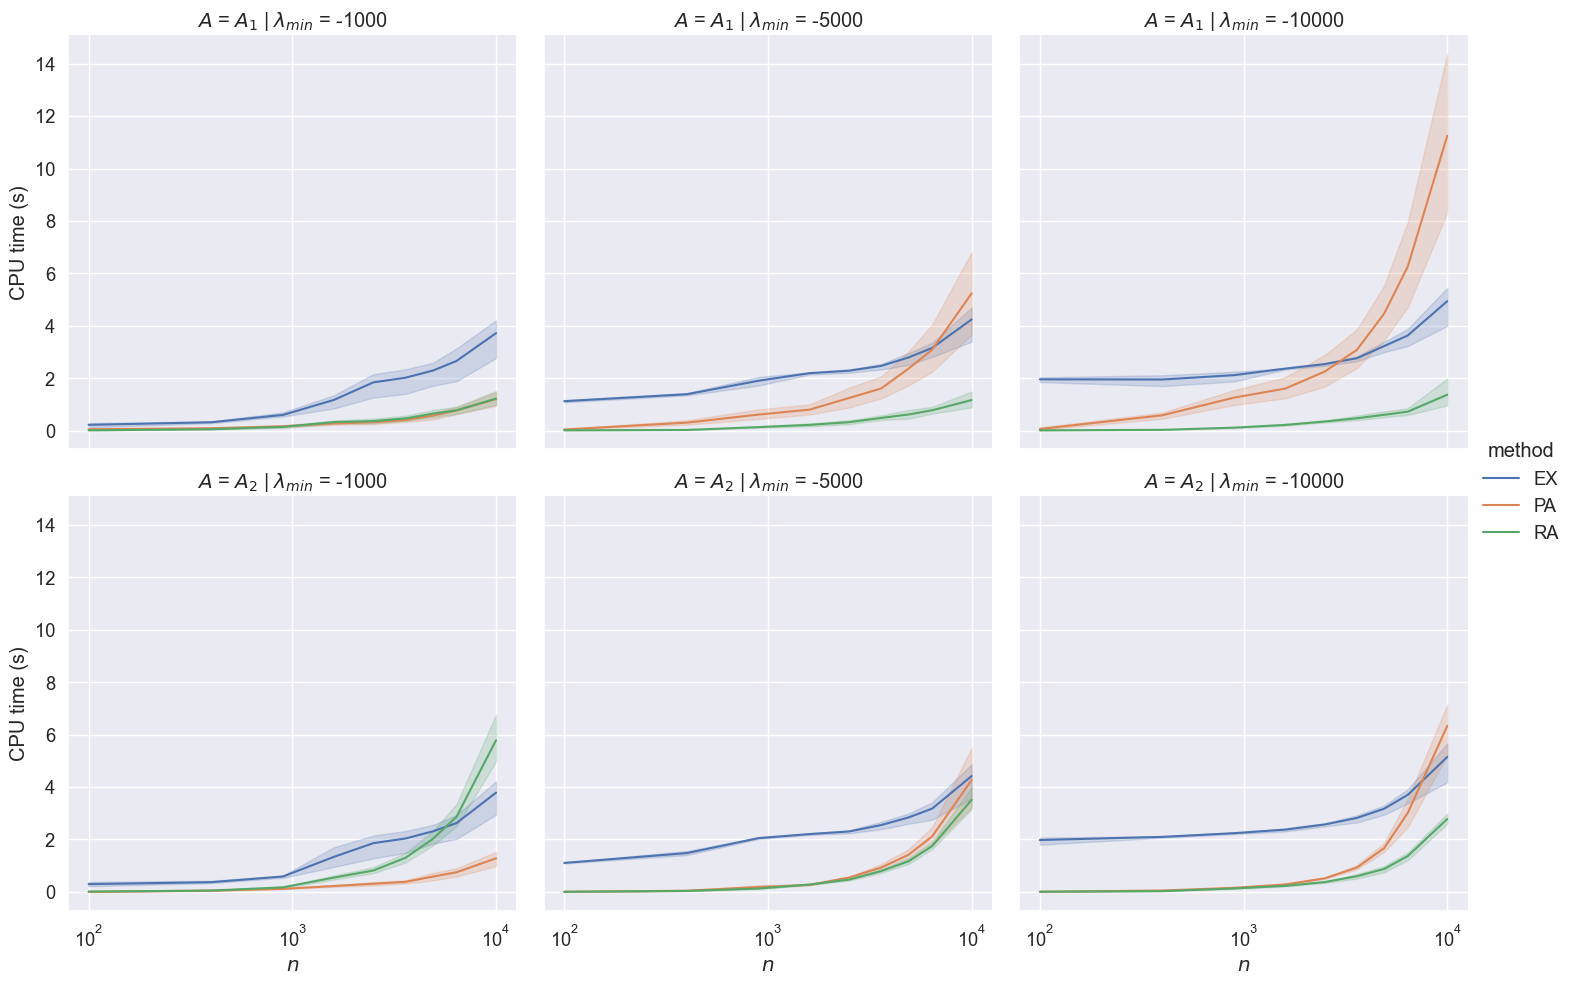

In [80]:
data = df[
    ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))
    # & ((df['a'] == -1000) | (df['a'] == -10000))
]

thresh = 1e-12
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda_{min}$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda_{min}$', 'p', '$A$', 'n']).aggregate(np.min)


fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    row='$A$',
    col='$\\lambda_{min}$',
    col_order=[-1000, -5000, -10000],
    # facet_kws={'sharey': False}
)
fg.set(
    xscale='log',
    ylabel='CPU time (s)',
    xlabel='$n$',
)